In [1]:
from hdbscan import HDBSCAN
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
from load_data import load

In [2]:
years = [x for x in range(2019, 2024)]
df = load(zhvi_years=years, zori_years=years, sale_listings_years=years, sales_years=years, days_on_market_years=years,
          new_cons_years=years)

In [3]:
df.head()

,RegionID,SizeRankZip,RegionName,RegionType,State,City,Metro,CountyName,ZHVI 2019,ZHVI 2020,...,Transit Jobs,Transit Trips/Week,Transit Routes,Transit Shed (sq mi),Transit percentage,Population,Unnamed: 0,STATEFP,COUNTYFP,NatWalkInd
0,91982,1,77494,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,321388.348443,328472.632957,...,56,40,0.0,0.0,0.013,"24,783",38085.0,48.0,157.0,7.968900
1,91940,3,77449,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,188081.681518,195719.086982,...,56,40,0.0,0.0,0.013,"24,783",38107.0,48.0,201.0,11.430193
2,91733,5,77084,zip,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,183263.902363,191893.515225,...,"218,774","1,900",5.0,31.0,0.039,"2,439,835",38107.0,48.0,201.0,11.430193
3,91926,11,77433,zip,TX,Cypress,"Houston-The Woodlands-Sugar Land, TX",Harris County,289271.507413,299620.783033,...,NaN,NaN,NaN,NaN,NaN,NaN,38107.0,48.0,201.0,11.430193
4,92036,25,77573,zip,TX,League City,"Houston-The Woodlands-Sugar Land, TX",Galveston County,274064.883079,284813.747796,...,NaN,NaN,NaN,NaN,NaN,NaN,38090.0,48.0,167.0,7.878866


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124315 entries, 0 to 124314
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   RegionID               124315 non-null  int64  
 1   SizeRankZip            124315 non-null  int64  
 2   RegionName             124315 non-null  int64  
 3   RegionType             124315 non-null  object 
 4   State                  124315 non-null  object 
 5   City                   115971 non-null  object 
 6   Metro                  7716 non-null    object 
 7   CountyName             124315 non-null  object 
 8   ZHVI 2019              105359 non-null  float64
 9   ZHVI 2020              105897 non-null  float64
 10  ZHVI 2021              109397 non-null  float64
 11  ZHVI 2022              120191 non-null  float64
 12  ZHVI 2023              123336 non-null  float64
 13  ZHVF BaseDate          8963 non-null    object 
 14  ZHVF 2024-02-29        8963 non-null

In [5]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167 entries, 0 to 7451
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RegionID               1167 non-null   int64  
 1   SizeRankZip            1167 non-null   int64  
 2   RegionName             1167 non-null   int64  
 3   RegionType             1167 non-null   object 
 4   State                  1167 non-null   object 
 5   City                   1167 non-null   object 
 6   Metro                  1167 non-null   object 
 7   CountyName             1167 non-null   object 
 8   ZHVI 2019              1167 non-null   float64
 9   ZHVI 2020              1167 non-null   float64
 10  ZHVI 2021              1167 non-null   float64
 11  ZHVI 2022              1167 non-null   float64
 12  ZHVI 2023              1167 non-null   float64
 13  ZHVF BaseDate          1167 non-null   object 
 14  ZHVF 2024-02-29        1167 non-null   float64
 15  ZHVF 2024

In [6]:
df.columns

Index(['RegionID', 'SizeRankZip', 'RegionName', 'RegionType', 'State', 'City',
       'Metro', 'CountyName', 'ZHVI 2019', 'ZHVI 2020', 'ZHVI 2021',
       'ZHVI 2022', 'ZHVI 2023', 'ZHVF BaseDate', 'ZHVF 2024-02-29',
       'ZHVF 2024-04-30', 'ZHVF 2025-01-31', 'ZORI 2019', 'ZORI 2020',
       'ZORI 2021', 'ZORI 2022', 'ZORI 2023', 'SizeRankMSA',
       'Sale Listings 2019', 'Sale Listings 2020', 'Sale Listings 2021',
       'Sale Listings 2022', 'Sale Listings 2023', 'Sales 2019', 'Sales 2020',
       'Sales 2021', 'Sales 2022', 'Sales 2023', 'Days on Market 2019',
       'Days on Market 2020', 'Days on Market 2021', 'Days on Market 2022',
       'Days on Market 2023', 'New Construction 2019', 'New Construction 2020',
       'New Construction 2021', 'New Construction 2022',
       'New Construction 2023', 'Transit Rank', 'Transit Score', 'Transit TCI',
       'Transit Jobs', 'Transit Trips/Week', 'Transit Routes',
       'Transit Shed (sq mi)', 'Transit percentage', 'Population',
    

In [7]:
for x in ['ZHVI ', 'ZORI ', 'Sales ', 'Sale Listings ', 'Days on Market ', 'New Construction ']:
    for year in [z for z in range(2020, 2024)]:
        df['YoY ' + x + str(year)] = (df[x + str(year)] - df[x + str(year-1)])/df[x + str(year-1)]

In [8]:
for x in ['ZHVI', 'ZORI', 'Sales', 'Sale Listings', 'Days on Market', 'New Construction']:
    yrs = [y for y in range(2020, 2024)]
    df['Avg YoY ' + x] = df[['YoY ' + x + ' ' + str(z) for z in yrs]].mean(axis=1)

In [9]:
for x in ['ZHVI', 'ZORI', 'Sales', 'Sale Listings', 'Days on Market', 'New Construction']:
    for year in [y for y in range(1, 5)]:
        df[str(year) + 'yr pct change ' + x] = (df[x + ' ' + str(2023)] - df[x + ' ' + str(2023-year)])/df[x + ' ' + str(2023-year)]

In [10]:
df.head()

,RegionID,SizeRankZip,RegionName,RegionType,State,City,Metro,CountyName,ZHVI 2019,ZHVI 2020,...,3yr pct change Sale Listings,4yr pct change Sale Listings,1yr pct change Days on Market,2yr pct change Days on Market,3yr pct change Days on Market,4yr pct change Days on Market,1yr pct change New Construction,2yr pct change New Construction,3yr pct change New Construction,4yr pct change New Construction
0,91982,1,77494,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,321388.348443,328472.632957,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
1,91940,3,77449,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,188081.681518,195719.086982,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
2,91733,5,77084,zip,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,183263.902363,191893.515225,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
3,91926,11,77433,zip,TX,Cypress,"Houston-The Woodlands-Sugar Land, TX",Harris County,289271.507413,299620.783033,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
4,92036,25,77573,zip,TX,League City,"Houston-The Woodlands-Sugar Land, TX",Galveston County,274064.883079,284813.747796,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314


In [13]:
print([x for x in df.columns])

['RegionID', 'SizeRankZip', 'RegionName', 'RegionType', 'State', 'City', 'Metro', 'CountyName', 'ZHVI 2019', 'ZHVI 2020', 'ZHVI 2021', 'ZHVI 2022', 'ZHVI 2023', 'ZHVF BaseDate', 'ZHVF 2024-02-29', 'ZHVF 2024-04-30', 'ZHVF 2025-01-31', 'ZORI 2019', 'ZORI 2020', 'ZORI 2021', 'ZORI 2022', 'ZORI 2023', 'SizeRankMSA', 'Sale Listings 2019', 'Sale Listings 2020', 'Sale Listings 2021', 'Sale Listings 2022', 'Sale Listings 2023', 'Sales 2019', 'Sales 2020', 'Sales 2021', 'Sales 2022', 'Sales 2023', 'Days on Market 2019', 'Days on Market 2020', 'Days on Market 2021', 'Days on Market 2022', 'Days on Market 2023', 'New Construction 2019', 'New Construction 2020', 'New Construction 2021', 'New Construction 2022', 'New Construction 2023', 'Transit Rank', 'Transit Score', 'Transit TCI', 'Transit Jobs', 'Transit Trips/Week', 'Transit Routes', 'Transit Shed (sq mi)', 'Transit percentage', 'Population', 'Unnamed: 0', 'STATEFP', 'COUNTYFP', 'NatWalkInd', 'YoY ZHVI 2020', 'YoY ZHVI 2021', 'YoY ZHVI 2022',

In [16]:
c_df = df[['ZHVI 2023', 'ZORI 2023', 'Sales 2023', 'Days on Market 2023', 'Sale Listings 2023', 'New Construction 2023',
    'ZHVF 2024-02-29', 'ZHVF 2024-04-30', 'ZHVF 2025-01-31', 'Transit Score', 'NatWalkInd', '1yr pct change ZHVI',
    '2yr pct change ZHVI', '3yr pct change ZHVI', '1yr pct change ZORI', '2yr pct change ZORI', '3yr pct change ZORI',
    '1yr pct change Sales', '2yr pct change Sales', '3yr pct change Sales', '1yr pct change Sale Listings',
    '2yr pct change Sale Listings', '3yr pct change Sale Listings', '1yr pct change Days on Market', '2yr pct change Days on Market',
    '3yr pct change Days on Market', '1yr pct change New Construction', '2yr pct change New Construction',
    '3yr pct change New Construction']]
c_df.describe()

,ZHVI 2023,ZORI 2023,Sales 2023,Days on Market 2023,Sale Listings 2023,New Construction 2023,ZHVF 2024-02-29,ZHVF 2024-04-30,ZHVF 2025-01-31,Transit Score,...,3yr pct change Sales,1yr pct change Sale Listings,2yr pct change Sale Listings,3yr pct change Sale Listings,1yr pct change Days on Market,2yr pct change Days on Market,3yr pct change Days on Market,1yr pct change New Construction,2yr pct change New Construction,3yr pct change New Construction
count,1.233360e+05,3475.000000,8089.000000,74775.000000,124315.000000,32214.000000,8963.000000,8963.000000,8963.000000,3981.000000,...,8089.000000,124104.000000,123502.000000,119646.000000,67062.000000,66111.000000,58982.000000,26468.000000,25812.000000,23794.000000
mean,2.041179e+05,2079.177800,3363.972803,44.175617,923.137804,110.868701,0.149370,0.865257,3.152761,5.062070,...,-0.282900,0.142397,0.003663,-0.154711,0.350661,0.283480,-0.319378,-0.050115,-0.016782,0.204009
std,1.529011e+05,2813.719464,2920.628919,14.951368,3466.147603,245.913543,0.396374,1.020623,1.492358,2.547507,...,0.082774,2.650163,0.350389,0.374813,0.258781,0.418433,0.229493,0.284547,0.421503,0.530909
min,2.634527e+04,781.741256,236.166667,15.666667,17.583333,5.000000,-3.000000,-4.500000,-5.100000,0.000000,...,-0.577204,-0.462222,-0.546489,-0.754363,-0.351703,-0.440803,-0.703761,-0.575820,-0.578488,-0.621212
25%,1.247221e+05,1486.569356,1099.833333,32.833333,116.666667,14.666667,0.000000,0.500000,2.100000,3.200000,...,-0.323050,-0.155253,-0.205675,-0.391371,0.161049,-0.043697,-0.484761,-0.216769,-0.283195,-0.152812
50%,1.673042e+05,1828.951690,2519.000000,41.916667,227.500000,25.750000,0.200000,1.000000,3.300000,5.100000,...,-0.290151,-0.065442,-0.059927,-0.249122,0.313043,0.195719,-0.363492,-0.108158,-0.110526,0.090851
75%,2.349861e+05,2284.776407,5093.833333,53.416667,450.416667,86.750000,0.400000,1.400000,4.200000,6.900000,...,-0.242460,0.043960,0.149566,-0.010110,0.516529,0.478134,-0.218462,0.035184,0.112906,0.433673
max,5.257469e+06,132538.681974,11924.166667,99.250000,43696.666667,1851.250000,3.000000,5.300000,8.500000,9.600000,...,0.111924,45.003636,3.963636,3.433657,1.208191,2.189024,0.644654,1.923636,2.138629,2.723611


In [17]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124315 entries, 0 to 124314
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ZHVI 2023                        123336 non-null  float64
 1   ZORI 2023                        3475 non-null    float64
 2   Sales 2023                       8089 non-null    float64
 3   Days on Market 2023              74775 non-null   float64
 4   Sale Listings 2023               124315 non-null  float64
 5   New Construction 2023            32214 non-null   float64
 6   ZHVF 2024-02-29                  8963 non-null    float64
 7   ZHVF 2024-04-30                  8963 non-null    float64
 8   ZHVF 2025-01-31                  8963 non-null    float64
 9   Transit Score                    3981 non-null    float64
 10  NatWalkInd                       122980 non-null  float64
 11  1yr pct change ZHVI              120191 non-null  float64
 12  2y

In [18]:
c_df = c_df.drop(columns=['2yr pct change ZORI', '3yr pct change ZORI'])
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124315 entries, 0 to 124314
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ZHVI 2023                        123336 non-null  float64
 1   ZORI 2023                        3475 non-null    float64
 2   Sales 2023                       8089 non-null    float64
 3   Days on Market 2023              74775 non-null   float64
 4   Sale Listings 2023               124315 non-null  float64
 5   New Construction 2023            32214 non-null   float64
 6   ZHVF 2024-02-29                  8963 non-null    float64
 7   ZHVF 2024-04-30                  8963 non-null    float64
 8   ZHVF 2025-01-31                  8963 non-null    float64
 9   Transit Score                    3981 non-null    float64
 10  NatWalkInd                       122980 non-null  float64
 11  1yr pct change ZHVI              120191 non-null  float64
 12  2y

In [19]:
c_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2198 entries, 0 to 7451
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ZHVI 2023                        2198 non-null   float64
 1   ZORI 2023                        2198 non-null   float64
 2   Sales 2023                       2198 non-null   float64
 3   Days on Market 2023              2198 non-null   float64
 4   Sale Listings 2023               2198 non-null   float64
 5   New Construction 2023            2198 non-null   float64
 6   ZHVF 2024-02-29                  2198 non-null   float64
 7   ZHVF 2024-04-30                  2198 non-null   float64
 8   ZHVF 2025-01-31                  2198 non-null   float64
 9   Transit Score                    2198 non-null   float64
 10  NatWalkInd                       2198 non-null   float64
 11  1yr pct change ZHVI              2198 non-null   float64
 12  2yr pct change ZHVI      

In [20]:
c_df = c_df.dropna()

<AxesSubplot:xlabel='1yr pct change ZHVI', ylabel='3yr pct change ZHVI'>

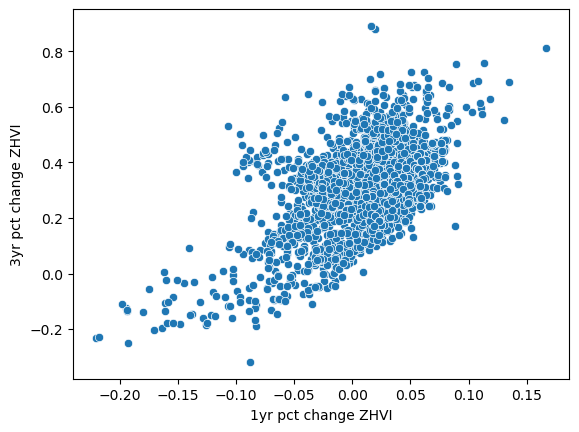

In [23]:
sns.scatterplot(data=c_df, x='1yr pct change ZHVI', y='3yr pct change ZHVI')

<AxesSubplot:xlabel='1yr pct change ZHVI', ylabel='1yr pct change ZORI'>

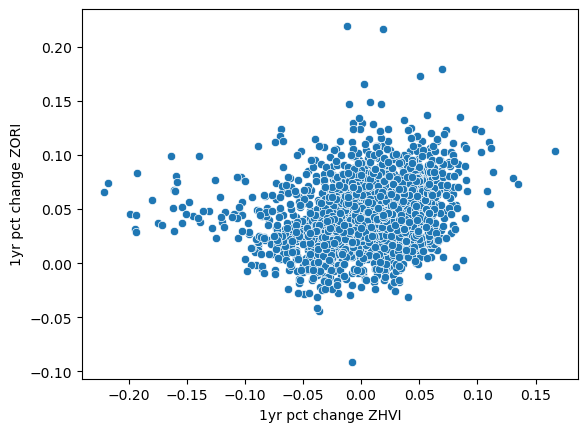

In [24]:
sns.scatterplot(data=c_df, x='1yr pct change ZHVI', y='1yr pct change ZORI')

<AxesSubplot:xlabel='1yr pct change Sales', ylabel='3yr pct change Sales'>

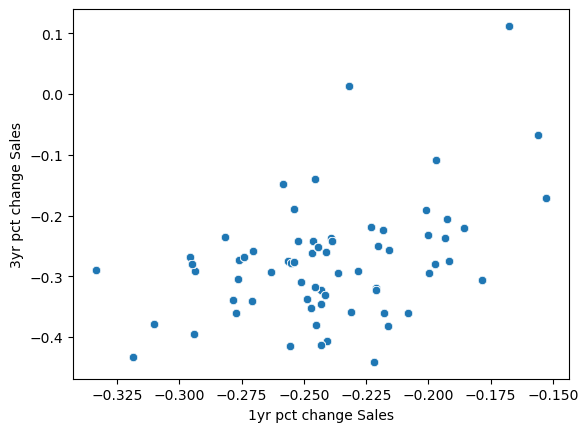

In [25]:
sns.scatterplot(data=c_df, x='1yr pct change Sales', y='3yr pct change Sales')

In [26]:
scaler = StandardScaler()
scaled_c_df = scaler.fit_transform(c_df)
scaled_c_df

array([[-0.13098453, -0.22144941,  0.43678743, ...,  0.07629736,
         0.68343211,  0.57350428],
       [-0.58997208, -0.28540036,  0.43678743, ...,  0.07629736,
         0.68343211,  0.57350428],
       [-0.60655501, -0.23127282,  0.43678743, ...,  0.07629736,
         0.68343211,  0.57350428],
       ...,
       [-0.38071147, -0.90797354, -1.15035998, ..., -1.26080277,
        -0.81175536, -1.04092431],
       [-0.75143825, -0.98618927, -1.15035998, ..., -1.26080277,
        -0.81175536, -1.04092431],
       [-0.67508536, -0.94624302, -1.15035998, ..., -1.26080277,
        -0.81175536, -1.04092431]])

In [60]:
clusterer = HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
labels = clusterer.fit_predict(scaled_c_df)

In [61]:
c_df['cluster'] = labels

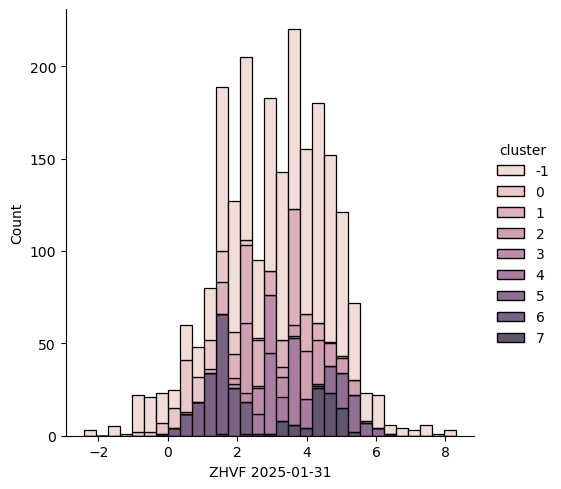

In [62]:
sns.displot(data=c_df, x='ZHVF 2025-01-31', hue='cluster', multiple='stack')

In [63]:
c_df['cluster'].value_counts().sort_index()

cluster
-1    1204
 0     112
 1     222
 2     132
 3      64
 4     132
 5      67
 6     178
 7      87
Name: count, dtype: int64

<AxesSubplot:>

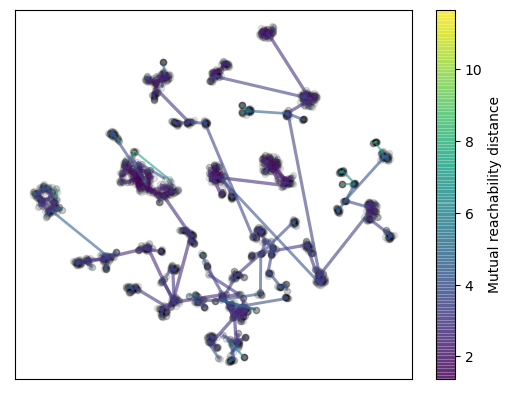

In [70]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=20, edge_linewidth=1, node_alpha=0.1)

<AxesSubplot:ylabel='distance'>

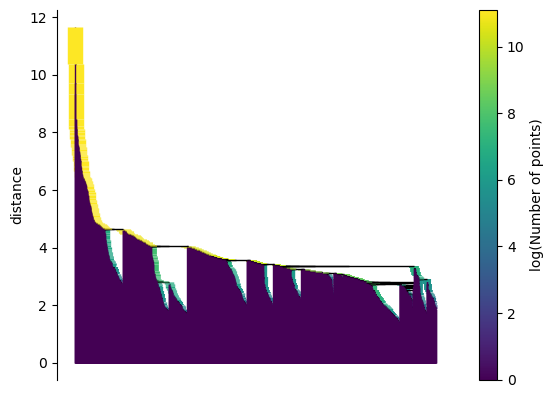

In [65]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

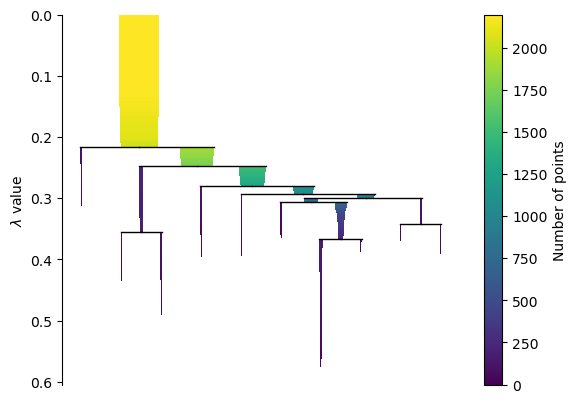

In [66]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

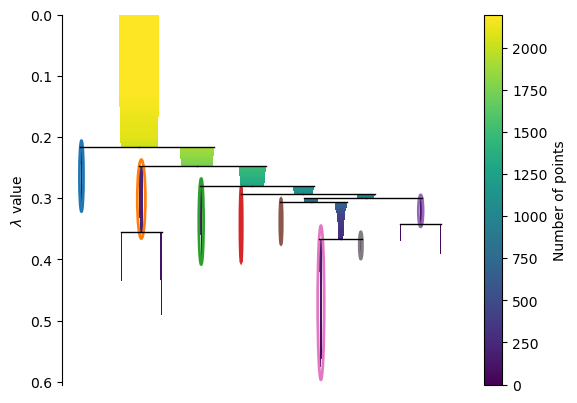

In [67]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [76]:
clusterers = []
clusters = []
for x in [10, 25, 50, 75, 100]:
    clusterer = clusterer = HDBSCAN(min_cluster_size=x)
    clusterers.append(clusterer)
    labels = clusterer.fit_predict(scaled_c_df)
    clusters.append(pd.Series(labels))

In [80]:
for x, y in zip(clusters, [10, 25, 50, 75, 100]):
    print("Min cluster size: " + str(y))
    print(x.value_counts().sort_index())
    print('='*20)

Min cluster size: 10
-1     317
 0      15
 1     123
 2      22
 3      37
 4     118
 5      15
 6      17
 7      72
 8      34
 9      11
 10     71
 11     20
 12     39
 13     54
 14     20
 15     12
 16     23
 17     65
 18     25
 19     68
 20     25
 21     37
 22     54
 23     97
 24     21
 25     45
 26     20
 27     87
 28     73
 29     25
 30     29
 31    207
 32     50
 33     46
 34     35
 35     16
 36     36
 37     52
 38     11
 39     14
 40     40
Name: count, dtype: int64
Min cluster size: 25
-1     783
 0     119
 1      32
 2      92
 3     116
 4      31
 5      40
 6      71
 7      83
 8      53
 9      87
 10     25
 11     48
 12     89
 13     36
 14     52
 15     75
 16    192
 17     38
 18     30
 19     34
 20     72
Name: count, dtype: int64
Min cluster size: 50
-1    1204
 0     112
 1     222
 2     132
 3      64
 4     132
 5      67
 6     178
 7      87
Name: count, dtype: int64
Min cluster size: 75
-1    844
 0     90
 1    221
 2   

<AxesSubplot:ylabel='$\\lambda$ value'>

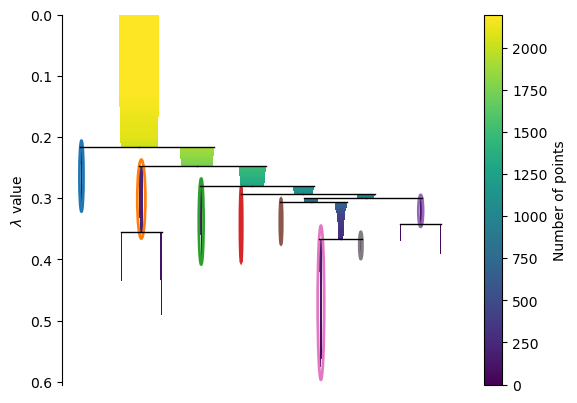

In [83]:
clusterers[-3].condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [89]:
min_sizes = []
cluster_ns = []
silhouettes = []
for x in range(5, 101, 5):
    clusterer = HDBSCAN(min_cluster_size=x)
    clusterers.append(clusterer)
    labels = clusterer.fit_predict(scaled_c_df)
    sil_score = silhouette_score(scaled_c_df, labels)
    n = len(np.unique(labels)) - 1
    min_sizes.append(x)
    cluster_ns.append(n)
    silhouettes.append(sil_score)

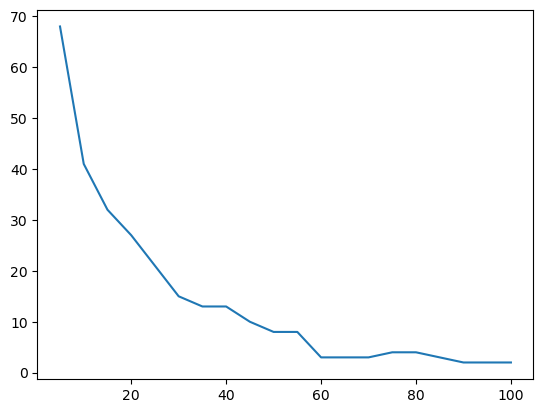

In [88]:
min_v_n = sns.lineplot(x=min_sizes, y=cluster_ns)

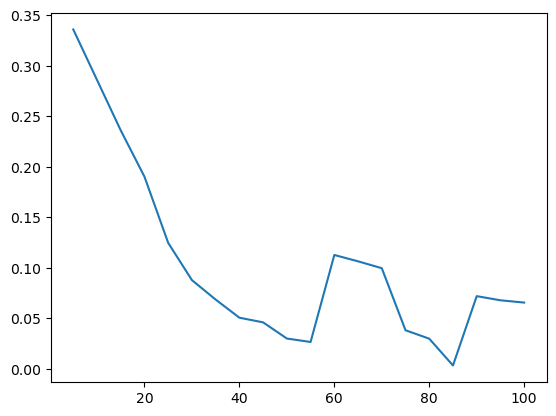

In [90]:
elbow = sns.lineplot(x=min_sizes, y=silhouettes)

In [91]:
clusterers = []
clusters = []
for x in range(35, 51, 5):
    clusterer = clusterer = HDBSCAN(min_cluster_size=x)
    clusterers.append(clusterer)
    labels = clusterer.fit_predict(scaled_c_df)
    clusters.append(pd.Series(labels))

In [92]:
for x, y in zip(clusters, [z for z in range(35, 51, 5)]):
    print("Min cluster size: " + str(y))
    print(x.value_counts().sort_index())
    print('='*20)

Min cluster size: 35
-1     982
 0     118
 1      87
 2     115
 3      71
 4      73
 5      53
 6      71
 7     134
 8      63
 9      48
 10     61
 11    186
 12    136
Name: count, dtype: int64
Min cluster size: 40
-1     1046
 0      118
 1       82
 2      115
 3       71
 4       52
 5       66
 6      131
 7       69
 8       59
 9       47
 10      40
 11     182
 12     120
Name: count, dtype: int64
Min cluster size: 45
-1    1146
 0     116
 1     223
 2      71
 3     130
 4      52
 5      63
 6      67
 7      57
 8     180
 9      93
Name: count, dtype: int64
Min cluster size: 50
-1    1204
 0     112
 1     222
 2     132
 3      64
 4     132
 5      67
 6     178
 7      87
Name: count, dtype: int64


In [93]:
c_df['cluster'] = clusters[2]

In [94]:
c_df.columns

Index(['ZHVI 2023', 'ZORI 2023', 'Sales 2023', 'Days on Market 2023',
       'Sale Listings 2023', 'New Construction 2023', 'ZHVF 2024-02-29',
       'ZHVF 2024-04-30', 'ZHVF 2025-01-31', 'Transit Score', 'NatWalkInd',
       '1yr pct change ZHVI', '2yr pct change ZHVI', '3yr pct change ZHVI',
       '1yr pct change ZORI', '1yr pct change Sales', '2yr pct change Sales',
       '3yr pct change Sales', '1yr pct change Sale Listings',
       '2yr pct change Sale Listings', '3yr pct change Sale Listings',
       '1yr pct change Days on Market', '2yr pct change Days on Market',
       '3yr pct change Days on Market', '1yr pct change New Construction',
       '2yr pct change New Construction', '3yr pct change New Construction',
       'cluster'],
      dtype='object')

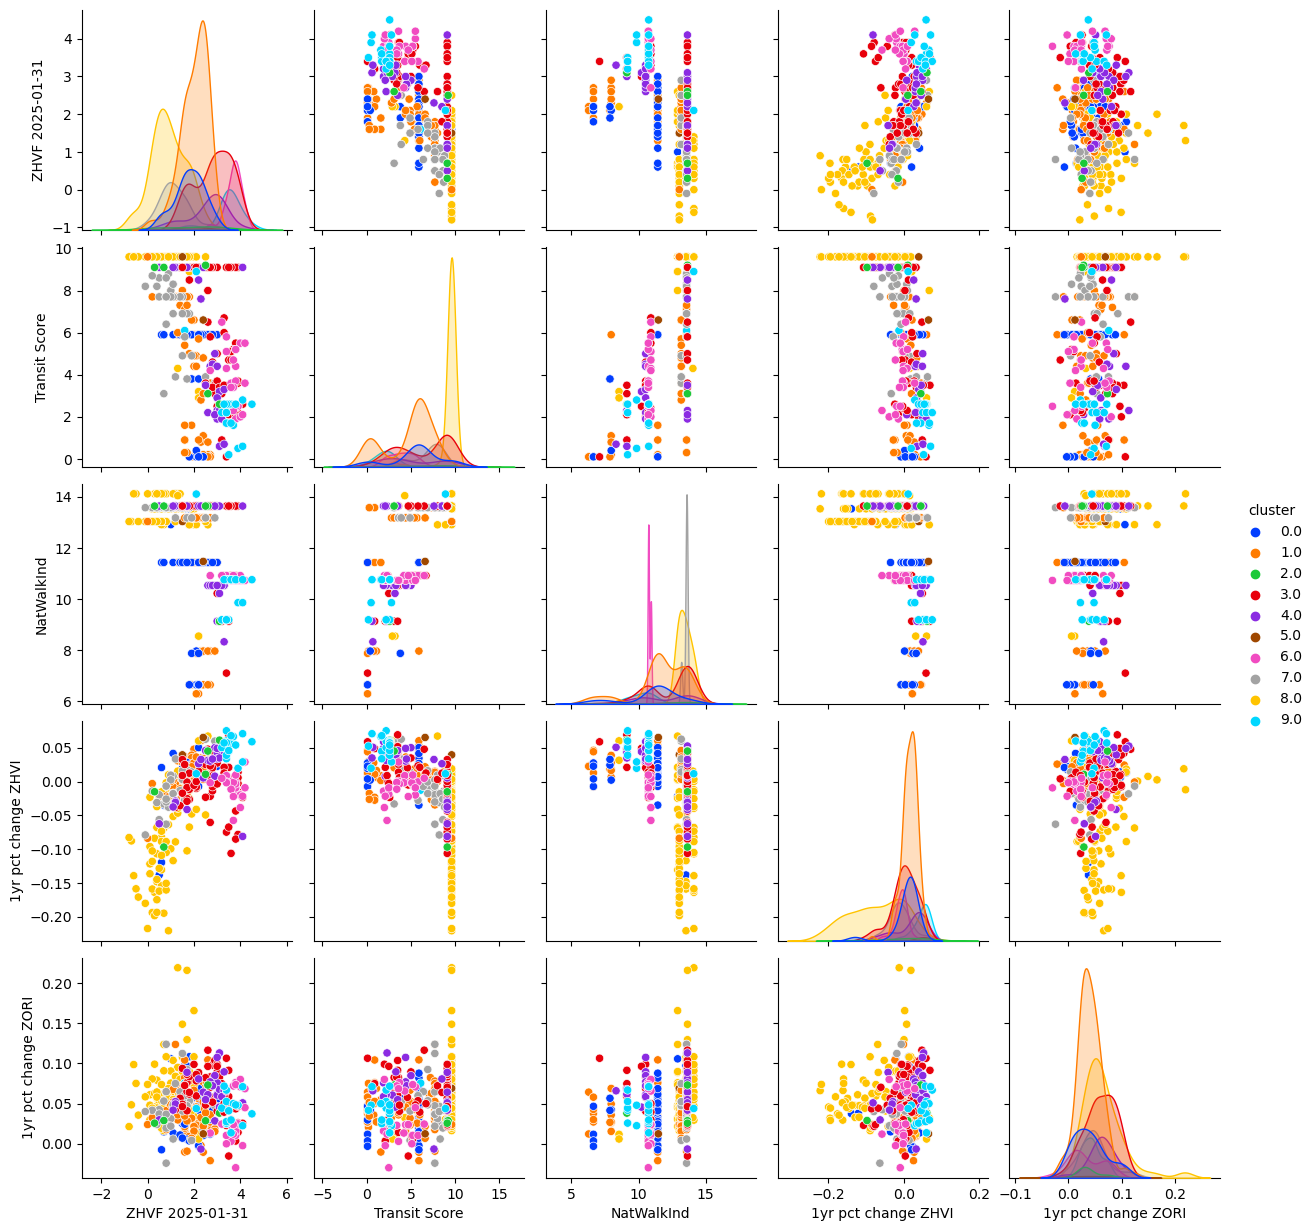

In [103]:
sns.pairplot(data=c_df[['cluster', 'ZHVF 2025-01-31', 'Transit Score', 'NatWalkInd',
                        '1yr pct change ZHVI', '1yr pct change ZORI']][c_df['cluster']!=-1], hue='cluster', palette='bright')

In [102]:
c_df[c_df['cluster']!=-1]

,ZHVI 2023,ZORI 2023,Sales 2023,Days on Market 2023,Sale Listings 2023,New Construction 2023,ZHVF 2024-02-29,ZHVF 2024-04-30,ZHVF 2025-01-31,Transit Score,...,1yr pct change Sale Listings,2yr pct change Sale Listings,3yr pct change Sale Listings,1yr pct change Days on Market,2yr pct change Days on Market,3yr pct change Days on Market,1yr pct change New Construction,2yr pct change New Construction,3yr pct change New Construction,cluster
0,473309.572520,1862.764273,5305.250000,46.500000,22046.333333,1851.250000,0.2,0.5,2.7,0.2,...,0.090782,0.069760,-0.183149,0.500000,0.391521,-0.208511,-0.036435,0.148656,0.258426,1.0
1,276410.405397,1810.344525,5305.250000,46.500000,22046.333333,1851.250000,0.1,0.6,2.6,0.2,...,0.090782,0.069760,-0.183149,0.500000,0.391521,-0.208511,-0.036435,0.148656,0.258426,1.0
2,269296.564130,1854.712147,5305.250000,46.500000,22046.333333,1851.250000,0.1,0.4,2.5,5.9,...,0.090782,0.069760,-0.183149,0.500000,0.391521,-0.208511,-0.036435,0.148656,0.258426,1.0
7,368646.998329,1823.993404,5305.250000,46.500000,22046.333333,1851.250000,0.1,0.3,2.2,0.1,...,0.090782,0.069760,-0.183149,0.500000,0.391521,-0.208511,-0.036435,0.148656,0.258426,1.0
8,358282.617576,1560.723145,5305.250000,46.500000,22046.333333,1851.250000,0.1,0.4,2.3,0.1,...,0.090782,0.069760,-0.183149,0.500000,0.391521,-0.208511,-0.036435,0.148656,0.258426,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,329572.772783,1456.475861,796.333333,33.666667,2169.000000,195.583333,0.2,0.8,1.5,0.2,...,-0.006375,-0.148354,-0.442846,0.355705,0.065963,-0.466314,-0.282702,-0.345145,-0.313743,NaN
7429,302608.150028,1578.471711,796.333333,33.666667,2169.000000,195.583333,0.2,0.6,2.0,1.1,...,-0.006375,-0.148354,-0.442846,0.355705,0.065963,-0.466314,-0.282702,-0.345145,-0.313743,NaN
7430,366180.248008,1300.029504,796.333333,33.666667,2169.000000,195.583333,0.2,0.5,2.0,2.2,...,-0.006375,-0.148354,-0.442846,0.355705,0.065963,-0.466314,-0.282702,-0.345145,-0.313743,NaN
7440,207143.702119,1235.917105,796.333333,33.666667,2169.000000,195.583333,0.1,0.5,2.3,5.0,...,-0.006375,-0.148354,-0.442846,0.355705,0.065963,-0.466314,-0.282702,-0.345145,-0.313743,NaN


In [104]:
df.head()

,RegionID,SizeRankZip,RegionName,RegionType,State,City,Metro,CountyName,ZHVI 2019,ZHVI 2020,...,3yr pct change Sale Listings,4yr pct change Sale Listings,1yr pct change Days on Market,2yr pct change Days on Market,3yr pct change Days on Market,4yr pct change Days on Market,1yr pct change New Construction,2yr pct change New Construction,3yr pct change New Construction,4yr pct change New Construction
0,91982,1,77494,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,321388.348443,328472.632957,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
1,91940,3,77449,zip,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,188081.681518,195719.086982,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
2,91733,5,77084,zip,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,183263.902363,191893.515225,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
3,91926,11,77433,zip,TX,Cypress,"Houston-The Woodlands-Sugar Land, TX",Harris County,289271.507413,299620.783033,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314
4,92036,25,77573,zip,TX,League City,"Houston-The Woodlands-Sugar Land, TX",Galveston County,274064.883079,284813.747796,...,-0.183149,-0.29387,0.5,0.391521,-0.208511,-0.265789,-0.036435,0.148656,0.258426,0.585314


In [105]:
len(df['Metro'].unique())

84

In [107]:
len(df['CountyName'].unique())

1100

In [112]:
numeric_columns = list(df.select_dtypes(include=['number']).columns)
county_df = df[numeric_columns+['CountyName']].groupby(by='CountyName').mean()
metro_df = df[numeric_columns+['Metro']].groupby(by='Metro').mean()

In [ ]:
sns.pairplot(county_df[['ZHVI 2023', 'ZORI 2023', 'Sales 2023', 'Days on Market 2023', 'Sale Listings 2023', 'New Construction 2023',
    'ZHVF 2025-01-31', 'Transit Score', 'NatWalkInd', '1yr pct change ZHVI',
    '1yr pct change ZORI',
    '1yr pct change Sales','1yr pct change Sale Listings',
    '1yr pct change Days on Market',
    '1yr pct change New Construction']])